In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import matplotlib.pyplot as plt
from utils import figure_8
from utils import net

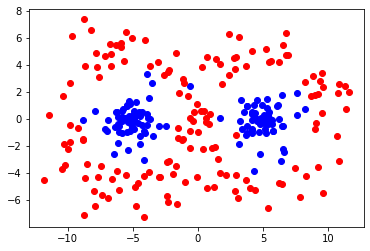

In [35]:
dataset = figure_8(150)
fig, ax = plt.subplots()
dataset.plot(ax)

In [37]:
net = net()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\noam\epfl_courses\opt_ML\opt_ml_env\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\noam\AppData\Local\Temp\ipykernel_71268\702337079.py", line 1, in <cell line: 1>
    net = net()
  File "c:\Users\noam\epfl_courses\opt_ML\opt_ML_project\utils.py", line 112, in __init__
    self.hidden_layers_list.append(self.layer_list[layer])
  File "C:\Users\noam\epfl_courses\opt_ML\opt_ml_env\lib\site-packages\torch\nn\modules\module.py", line 1177, in __getattr__
    raise AttributeError("'{}' object has no attribute '{}'".format(
AttributeError: 'net' object has no attribute 'hidden_layers_list'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\noam\epfl_courses\opt_ML\opt_ml_env\lib\site-packages\IPython\core\interactiveshell.py", line 1982, in showtraceback
    stb = self.Int